In [1]:
import sys
import pickle
sys.path.insert(0,'./')
# from importlib import reload

In [2]:
x={1:1,0:0}
1+ (x.get(1) or 0)

2

In [3]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
c=LocalCluster(n_workers=1,processes=False,memory_limit='25gb',threads_per_worker=14,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(c)

In [4]:
from cov_3X2 import *
from fisher import *

In [5]:
#only for python3
import importlib
reload=importlib.reload

# Lensing X Lensing Correlation function covariance

## Multiple redshift bins (Tomography)

In [6]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [7]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [8]:
import hankel_transform
from astropy.io import fits
reload(hankel_transform)
from hankel_transform import *


In [9]:
def readclxipm(filename):
    nz_bins=4
    na=20
    nz=np.int(nz_bins*(nz_bins+1.)/2.)
    print(nz)
    n_theta=ndesa=20
    tp_fits = fits.open(filename)[1].data #fitsio.FITS(filename)
    #xip = tp_fits['xip']
    #theta = xip['ang'][:ndesa]
    #thc = np.delete(theta,range(ndesa-na))

    ccl = tp_fits#[1]
    ccl_xip=ccl[:2*ndesa*nz,:2*ndesa*nz] #factor of 2 for xi_-
    #print ccl_xip[399,390:399]
    cov=np.zeros((2*nz*na,2*nz*na))
    for z1 in range(2*nz):
        for a1 in range(na):
            i1 = a1+z1*na
        ## The index in the original matrix is skewed because that matrix contains
        ## angles that have been cut. So 
            i1ccl = (a1+ndesa-na) + z1*ndesa
            for z2 in range(2*nz):
                for a2 in range(na):
                    i2 = a2 + z2*na
                ## The index in the original matrix is skewed because that matrix contains
                ## angles that have been cut. So 
                    i2ccl = (a2+ndesa-na) + z2*ndesa
                    cov[i1,i2]=ccl_xip[i1ccl,i2ccl]
    return cov

In [10]:
cosmo_params={'h': 0.7,
 'Omb': 0.05,
 'Omd': 0.236,
 's8': 0.82,
 'Om': 0.286,
 'As': 2.22e-09,
 'mnu': 0.0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.965,
 'w': -1,
 'wa': 0,
 'Oml': 1.-0.286}

In [11]:
fname='/home/deep/data/cosmolike/2pt_NG_0606.fits'
DES_dat=fits.open(fname)

In [12]:
cov_srd=np.genfromtxt('/home/deep/repos/DESC_SRD/cov/Y10_3x2pt_clusterN_clusterWL_cov',
                      names=('i1,i2,l1,l2,z1,z2,z3,z4,G,NG'))

In [13]:
cov_shear=np.genfromtxt('/home/deep/repos/DESC_SRD/cov/Y10_shear_shear_cov',)
covG_shear=np.genfromtxt('/home/deep/repos/DESC_SRD/cov/Y10_shear_shear_covG',) 
covNG_shear=np.genfromtxt('/home/deep/repos/DESC_SRD/cov/Y10_shear_shear_covNG',) 

l_min0=20
l_max0=15000
nl0=20
l_bins=np.logspace(np.log10(l_min0),np.log10(l_max0),nl0+1)
lb=0.5*(l_bins[1:]+l_bins[:-1])

lb15=np.tile(lb,15)
x=lb15<3000
cov_shear=cov_shear[x,x]
covG_shear=covG_shear[x,x]
covNG_shear=covNG_shear[x,x]

In [14]:
cov_des=readclxipm(filename=fname)
# corr_des=cc.corr_matrix(cov_des)

10


In [15]:
pz=Table.read(fname,format='fits',hdu=6)

In [16]:
f_sky=1348.8475/(4*np.pi/d2r**2)
# f_sky=4182./(4*np.pi/d2r**2)

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


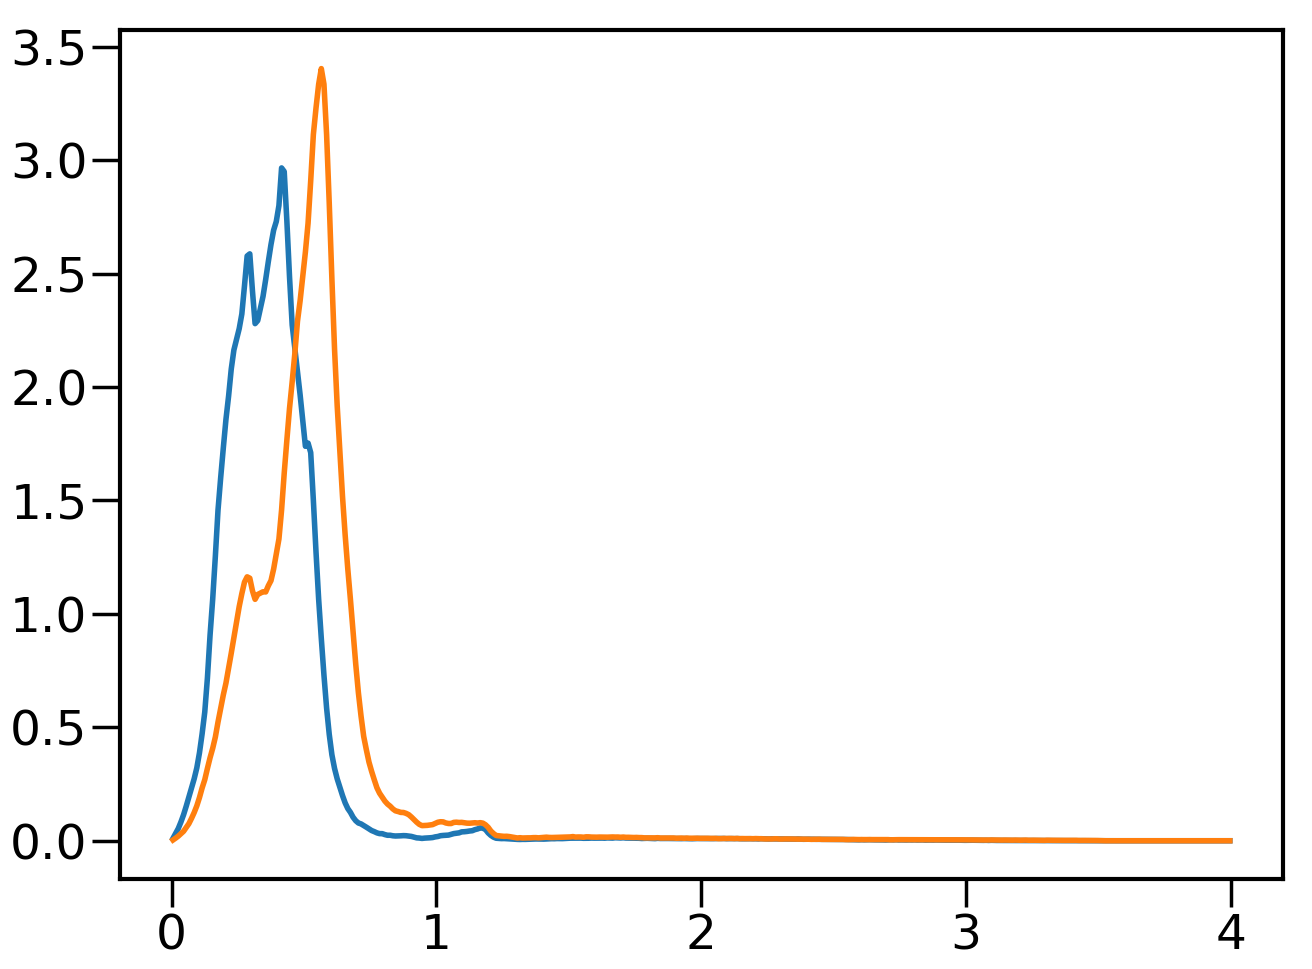

In [17]:
t=DES_dat[6].data
plot(t['Z_MID'],t['BIN1'])
plot(t['Z_MID'],t['BIN2'])

In [18]:
window_file='../../data/cosmolike/Cl_footprint_DES'
win=np.genfromtxt(window_file,names=('l','cl'))

In [19]:
#Setup redshift bins
zmin=0
zmax=3

nbins=4  # Number of tomographic bins
zs_bins=DES_bins(fname=fname)

ns0=np.sum(zs_bins['nz'])

In [20]:
zs_bins['nz']

[1.496, 1.5189, 1.5949, 0.7949]

In [21]:
do_xi=True
bin_xi=True
do_cov=True
bin_cl=False
th_min=2.5/60
th_max=250./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins*40)
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [22]:
#Hankel Transform setup
l_max=4e4
l_min=2
l0=np.arange(l_min,l_max)
prune_theta=1
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
                        'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2),(0,0)]}
# %time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

In [23]:
bin_xi=True
l_bins=None


In [24]:
use_window=False
do_sample_variance=True
SSV_cov=False
tidal_SSV=True
sigma_gamma=0.39/np.sqrt(2)

In [25]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [26]:
#use redshift bins from power spectrum part
XI_H =cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,zg_bins=None,l_bins=l_bins,
              do_sample_variance=do_sample_variance,use_window=use_window,window_file=window_file,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT_kwargs=HT_kwargs,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins,sigma_gamma=sigma_gamma)#ns=np.inf)
# XI_H2 = lensing_lensing(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
#                SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT_kwargs=HT_kwargs2,
#                bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

08:27:18 WARNING:cross covariance not implemented with Hankel Transform. m1_m2s: [(2, 2), (2, -2), (0, 0)]
08:27:18 INFO:pruning theta, log_space:True n_f:1
08:27:18 INFO:pruned theta:395
08:27:18 INFO:nr:394
08:27:23 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 41000
08:27:23 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 42000
08:27:23 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 43000
08:27:23 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 44000
08:27:23 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 45000
08:27:23 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 46000
08:27:23 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 47000
08:27:23 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 48000
08:27:23 INFO:j-nu=4 not enough zeros to cover l_min, increasing by 1000 to 49000
08:27:23 INFO:pruning theta, log_space:True n_f:1
08:

In [27]:
corr=('shear','shear')

In [28]:
%time xiHG=XI_H.xi_tomo(cosmo_params=cosmo_params)
# %time xiWG_L=XI_W_L.xi_tomo()

CPU times: user 7.22 s, sys: 56.4 ms, total: 7.27 s
Wall time: 5.09 s


In [29]:
%time xiH=xiHG['stack'].compute()
# %time xiH2=xiHG2['stack'].compute()

CPU times: user 24min 41s, sys: 8.47 s, total: 24min 49s
Wall time: 1min 50s


In [30]:
f=1
cov_xiH_inv=np.linalg.inv(xiH['cov']*f)
print (np.sqrt(np.dot(xiH['xi'],np.dot(cov_xiH_inv,xiH['xi']))))

# cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
# print (np.sqrt(np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

29.869314808521047


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
08:29:32 DEBUG:findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=42.0 to DejaVu Sans ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


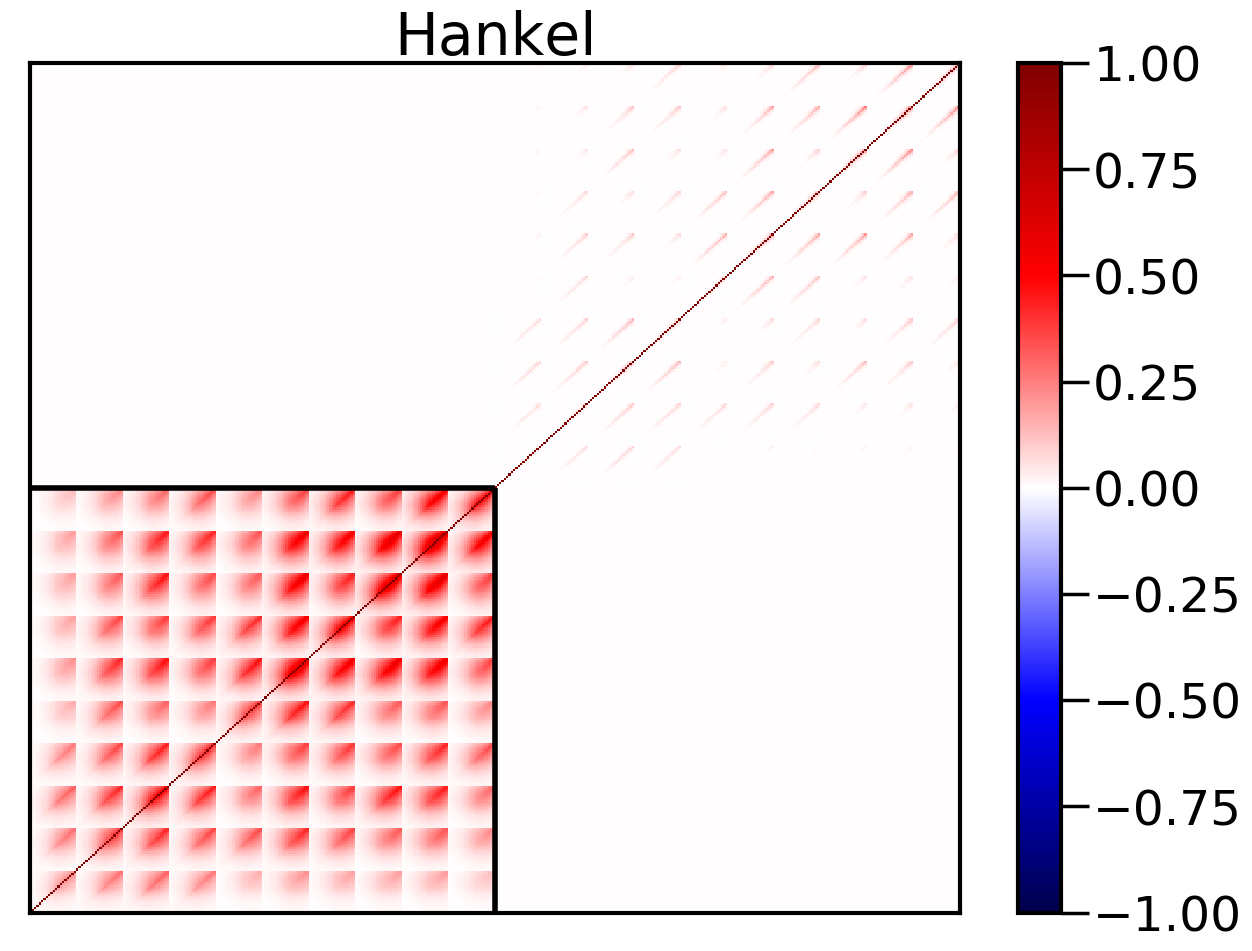

In [31]:
cc=XI_H.cov_utils
corrH=cc.corr_matrix(xiH['cov'])
pcolor(corrH,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Hankel')
hlines(200,0,200)
vlines(200,0,200)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


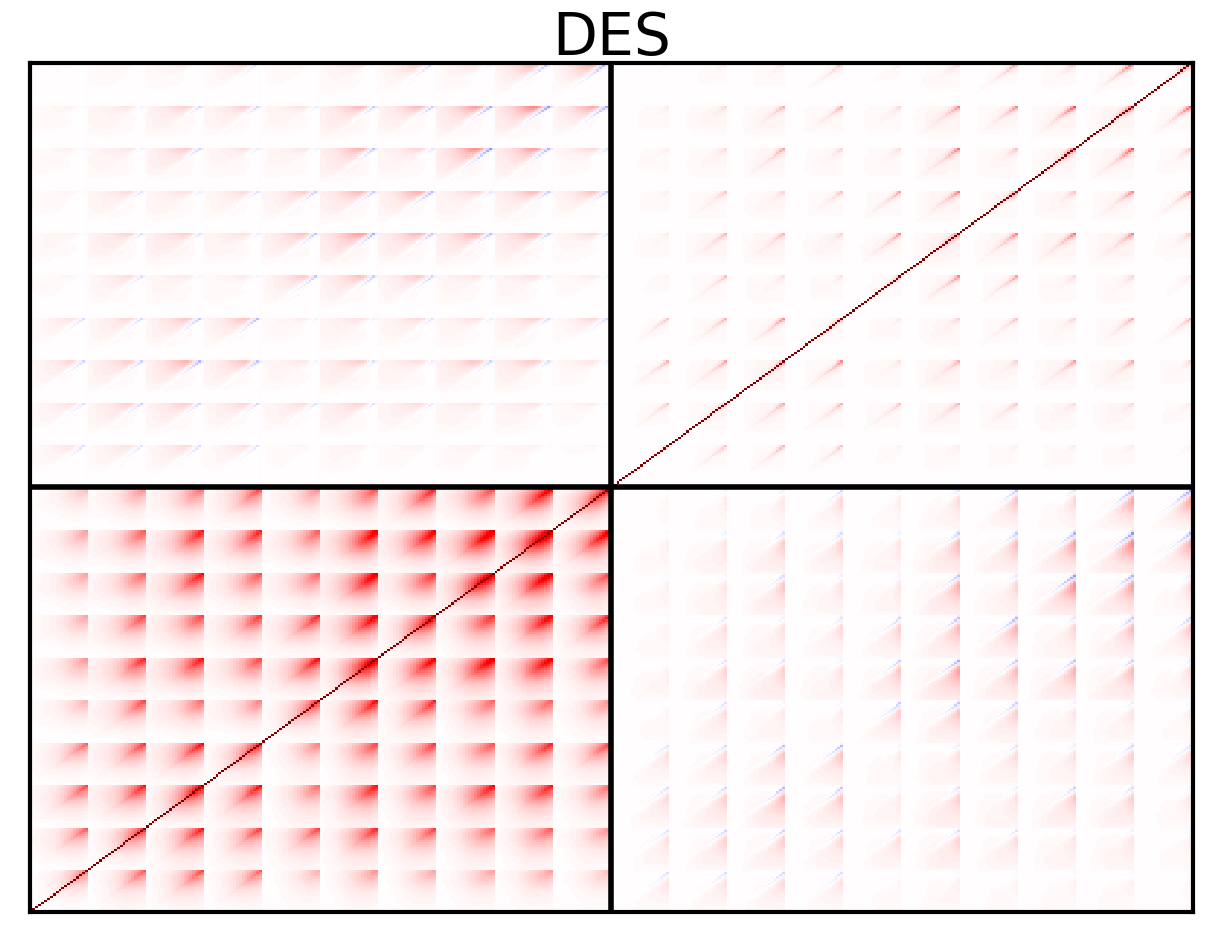

In [32]:
corr_des=cc.corr_matrix(cov_des)
pcolor(corr_des,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
hlines(n_th_bins*nbins*(nbins+1.)/2.,0,n_th_bins*nbins*(nbins+1.))
vlines(n_th_bins*nbins*(nbins+1.)/2.,0,n_th_bins*nbins*(nbins+1.))
xticks([])
yticks([])
title('DES')
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


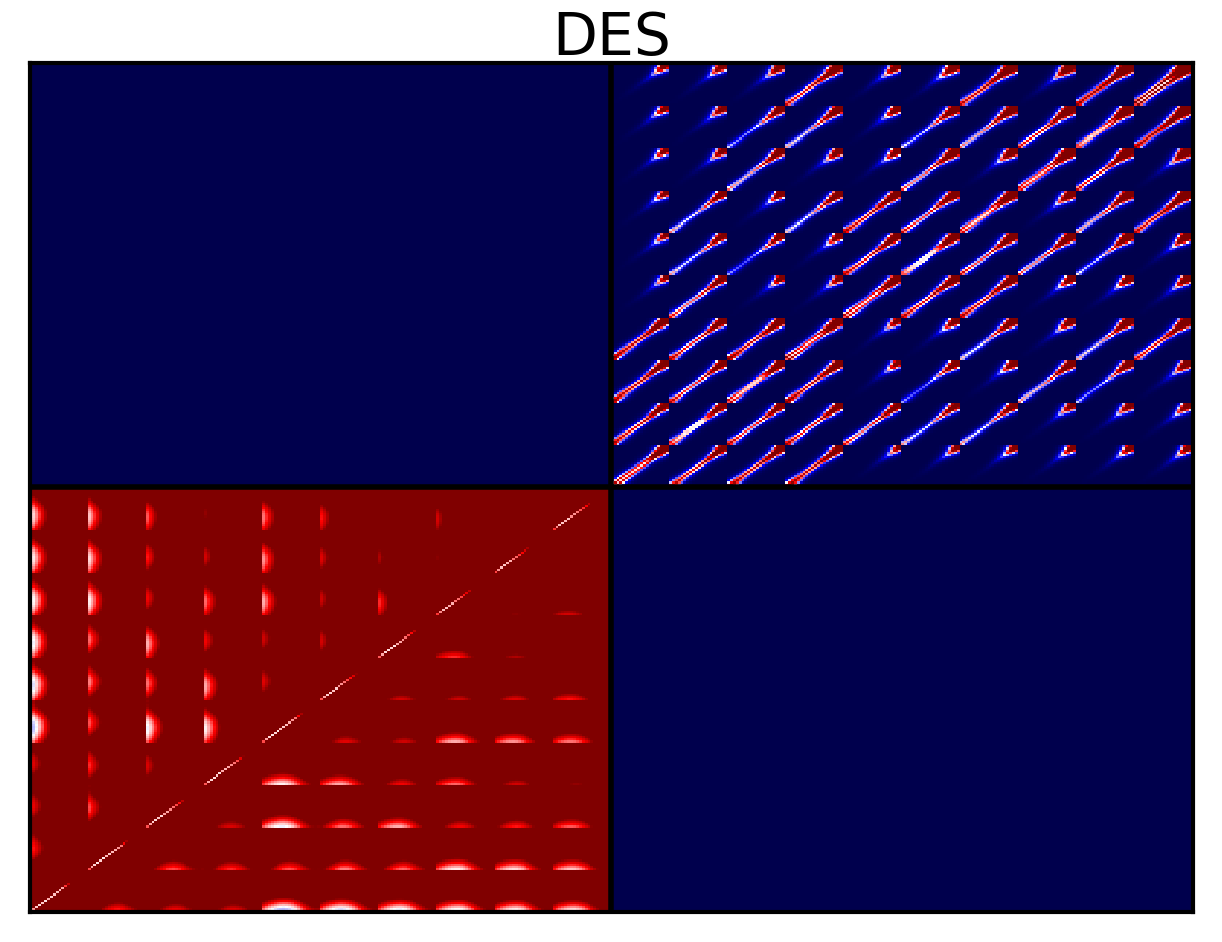

In [33]:
R=xiH['cov']/cov_des-1
# R=xiW_L['cov']/cov_des-1
pcolor(R,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
hlines(n_th_bins*nbins*(nbins+1.)/2.,0,n_th_bins*nbins*(nbins+1.))
vlines(n_th_bins*nbins*(nbins+1.)/2.,0,n_th_bins*nbins*(nbins+1.))
xticks([])
yticks([])
title('DES')
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [34]:
np.diag(R).max()

4.262217835307807

In [35]:
import pyccl as ccl
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],)#m_nu=[0,0,0.06])

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
08:30:08 DEBUG:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
08:30:08 DEBUG:findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
08:30:08 DEBUG:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf') with score of 0.000000
08:30:08 DEBUG:findfont: Matching :family=STIXNonUnicode:style=no

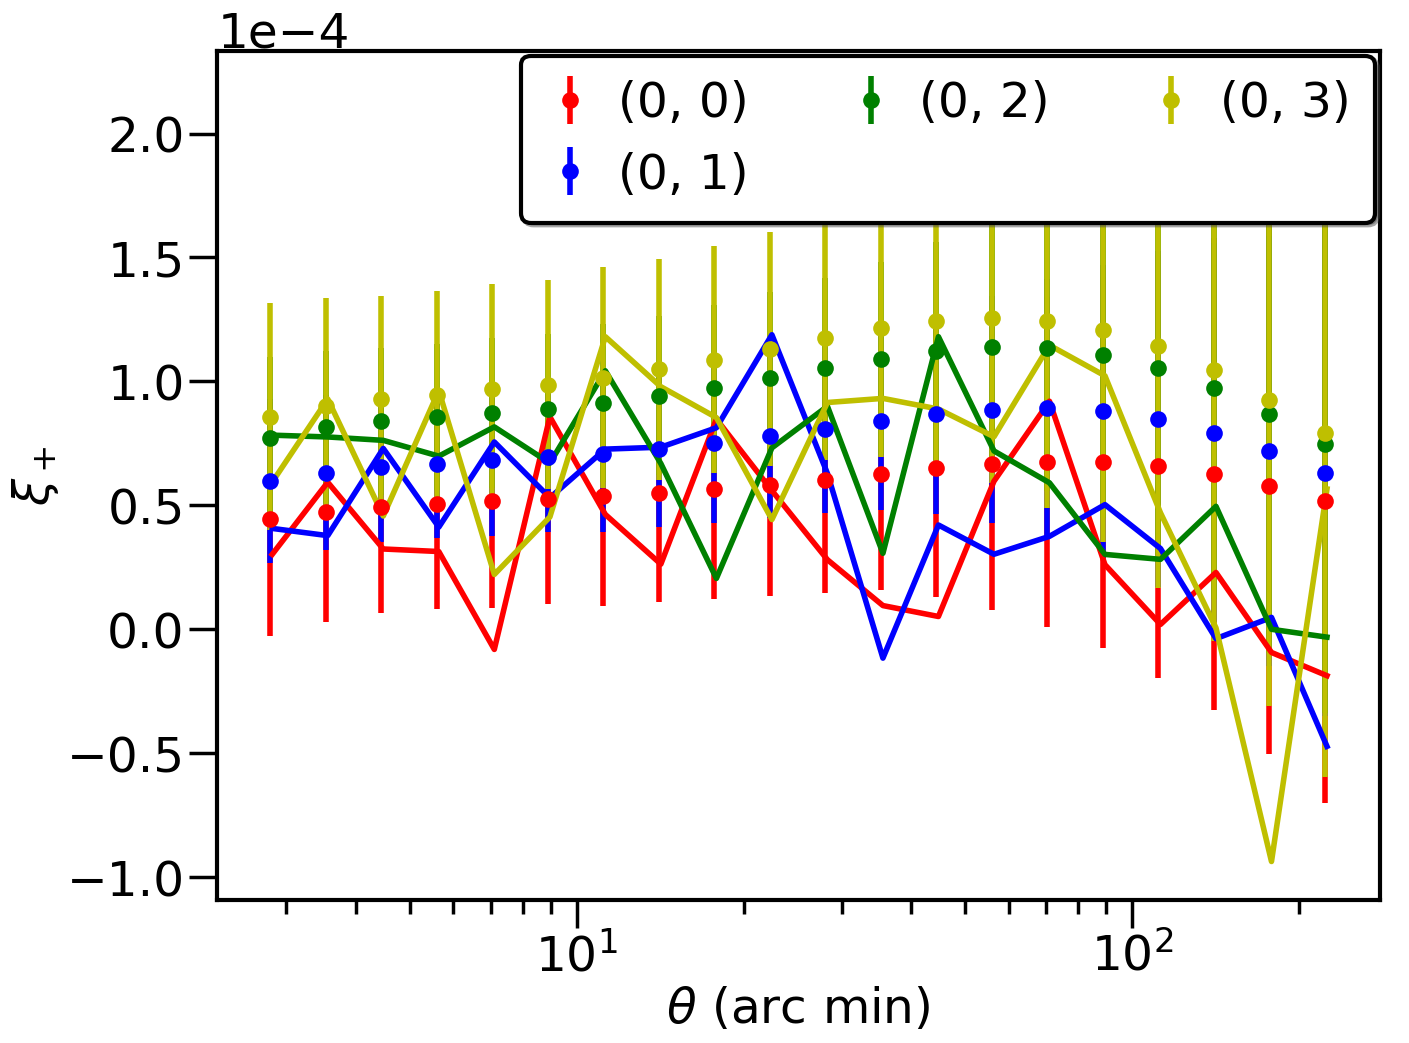

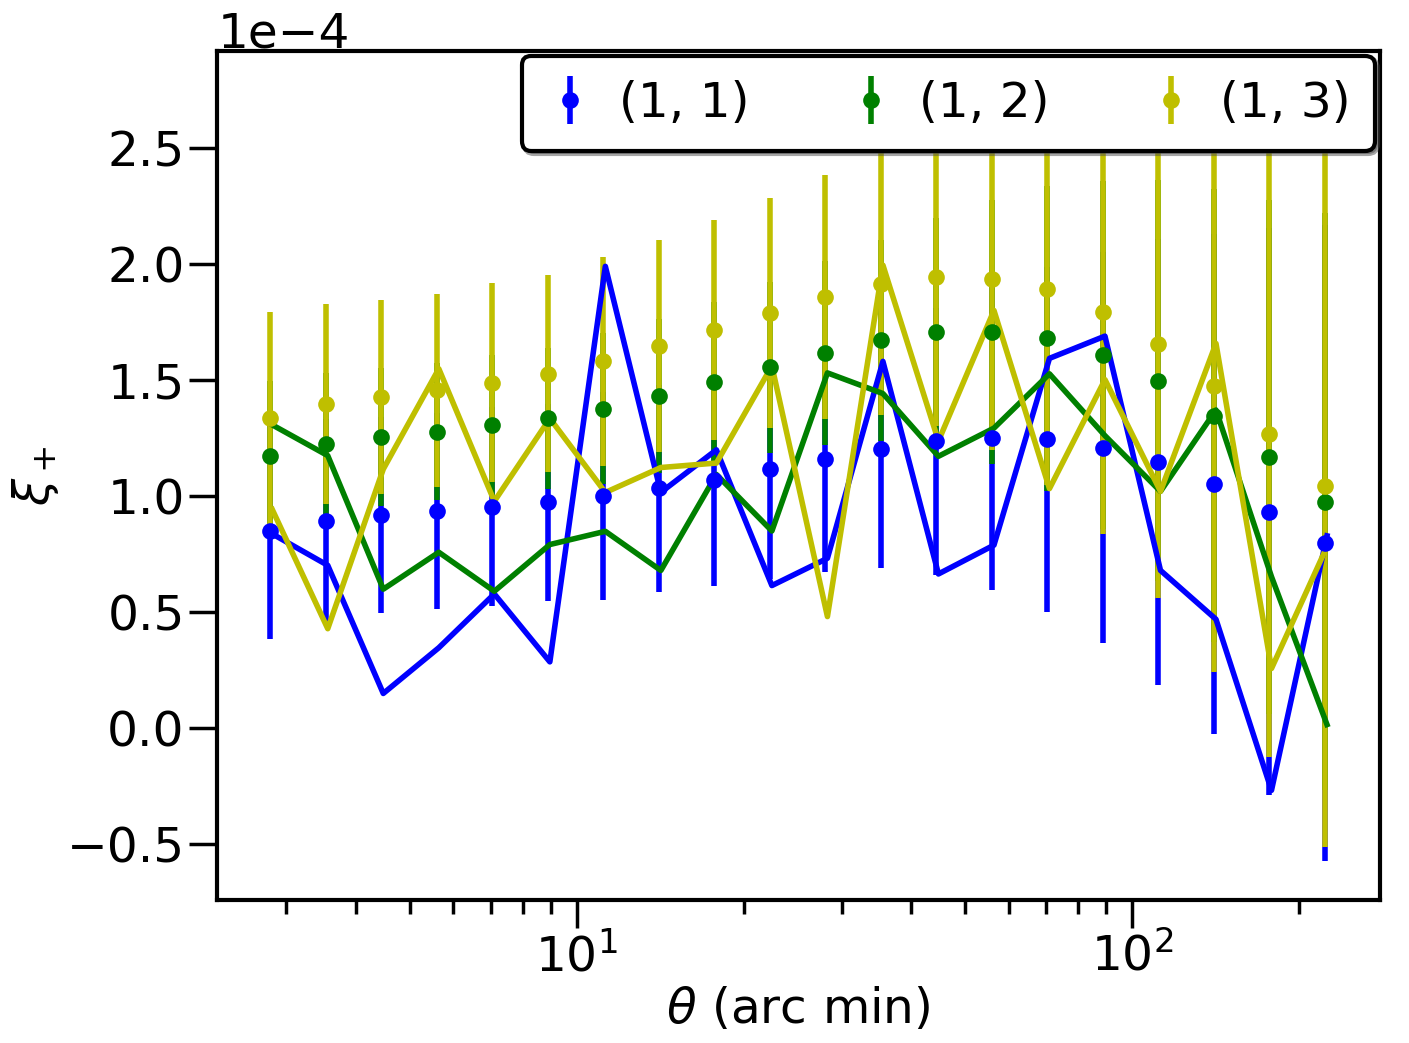

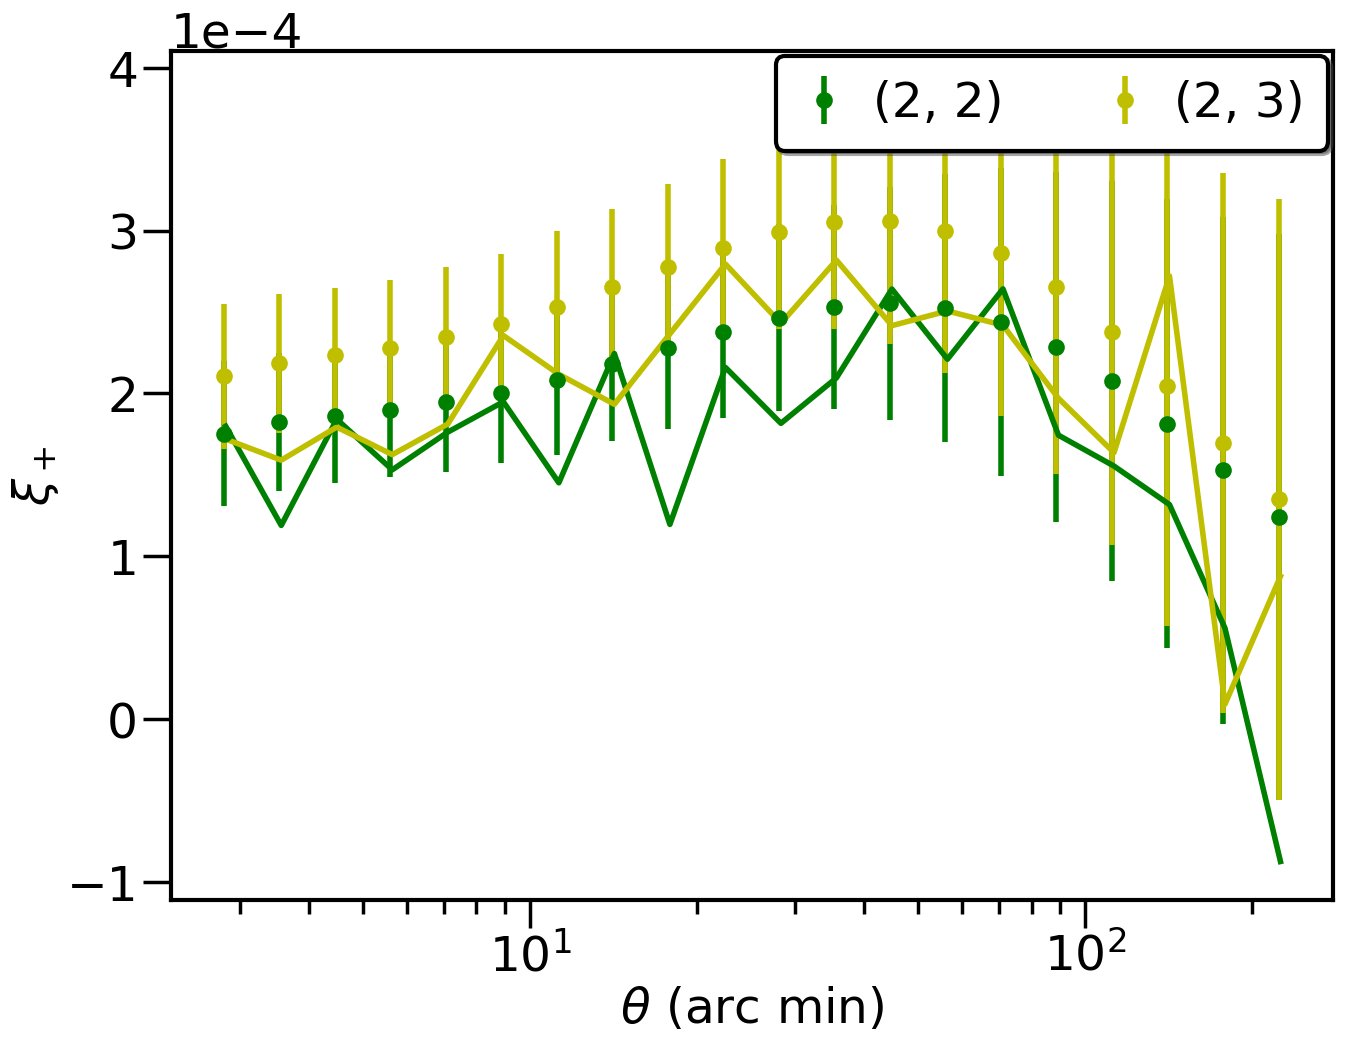

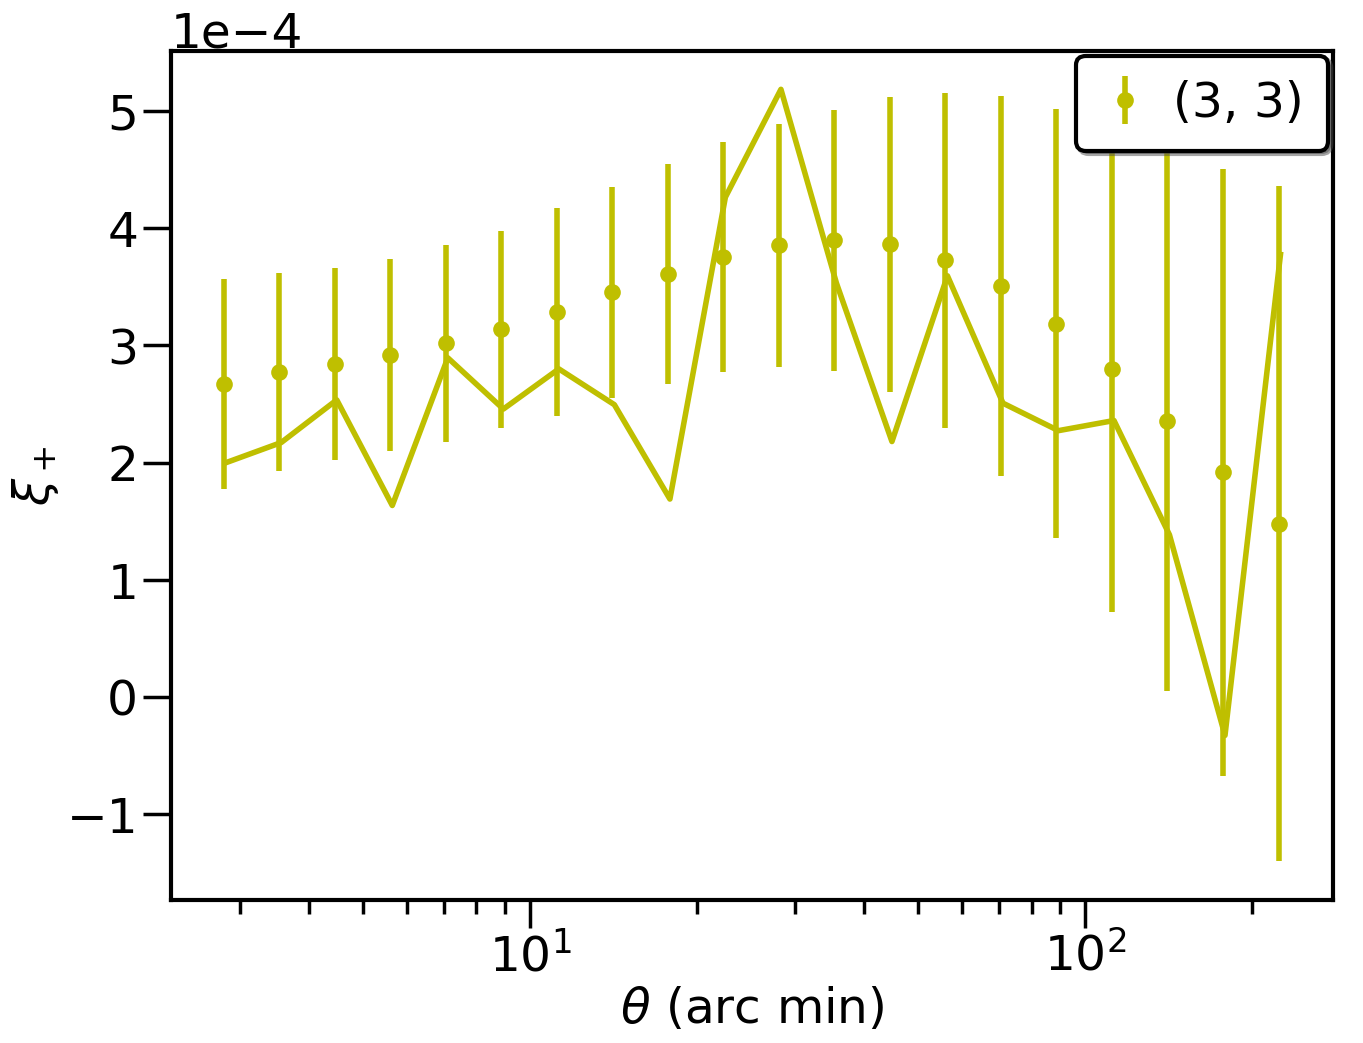

In [36]:
m1m2=(2,2)
cp=['r','b','g','y']#sns.color_pallete()
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        errorbar(thb*60,thb*60*xiHG['xi'][corr][m1m2][(i,j)].compute(),
                 thb*60*np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j),color=cp[j])
        x=DES_dat[2].data['BIN1']==i+1
        x*=DES_dat[2].data['BIN2']==j+1
        th_t=DES_dat[2].data['ANG'][x]
        plot(th_t,th_t*DES_dat[2].data['VALUE'][x],color=cp[j])
    xscale('log')
    # yscale('log')
    xlabel(r'$\theta$ (arc min)')
    ylabel(r'$\xi_+$')
    legend(ncol=3)
    show()

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


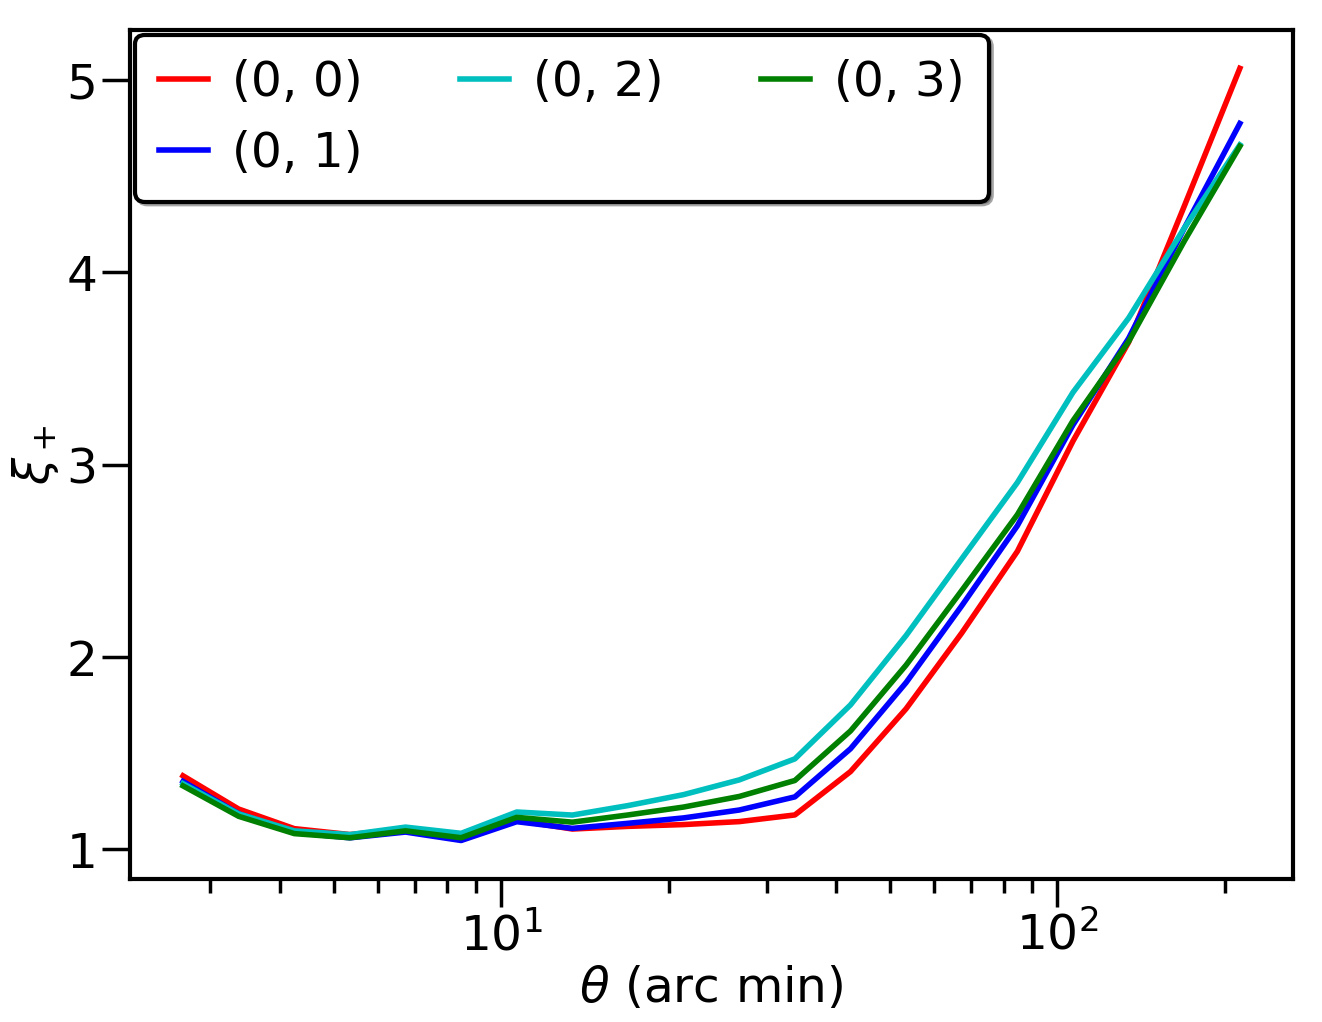

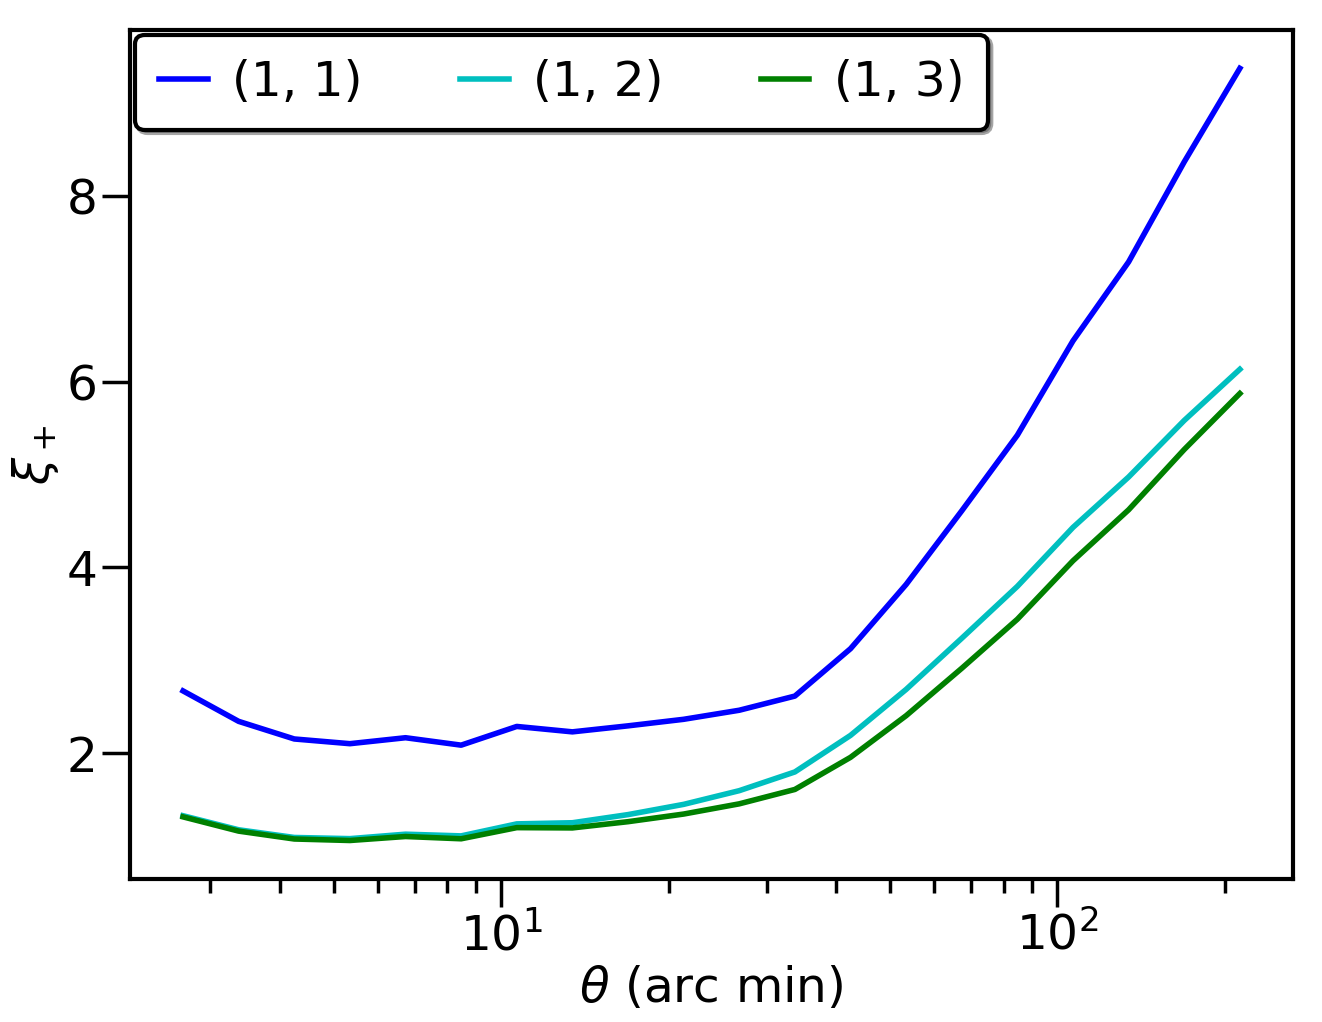

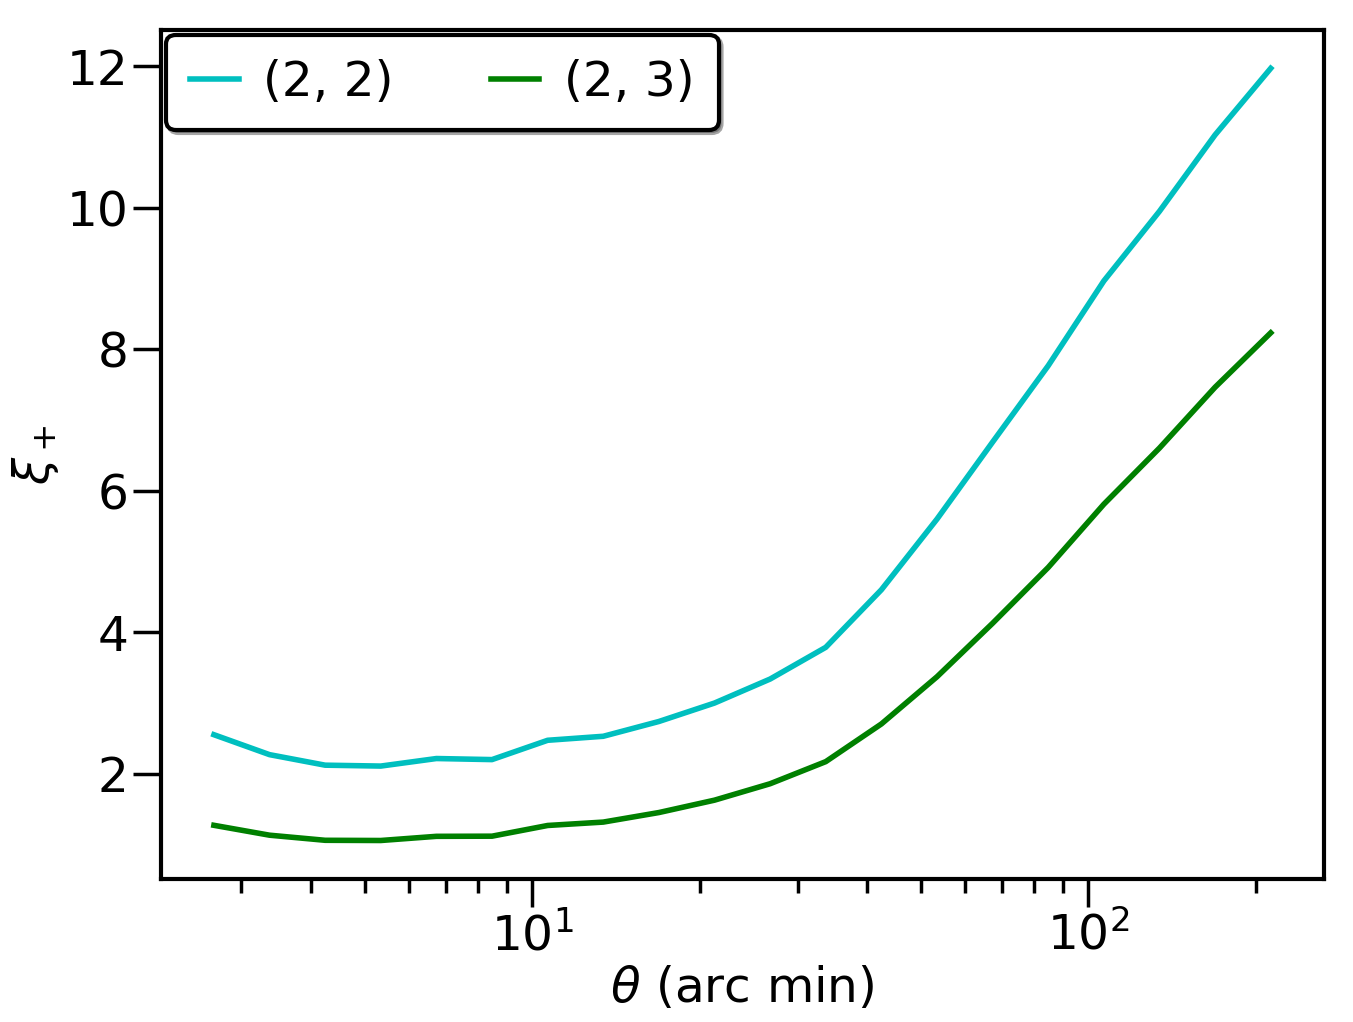

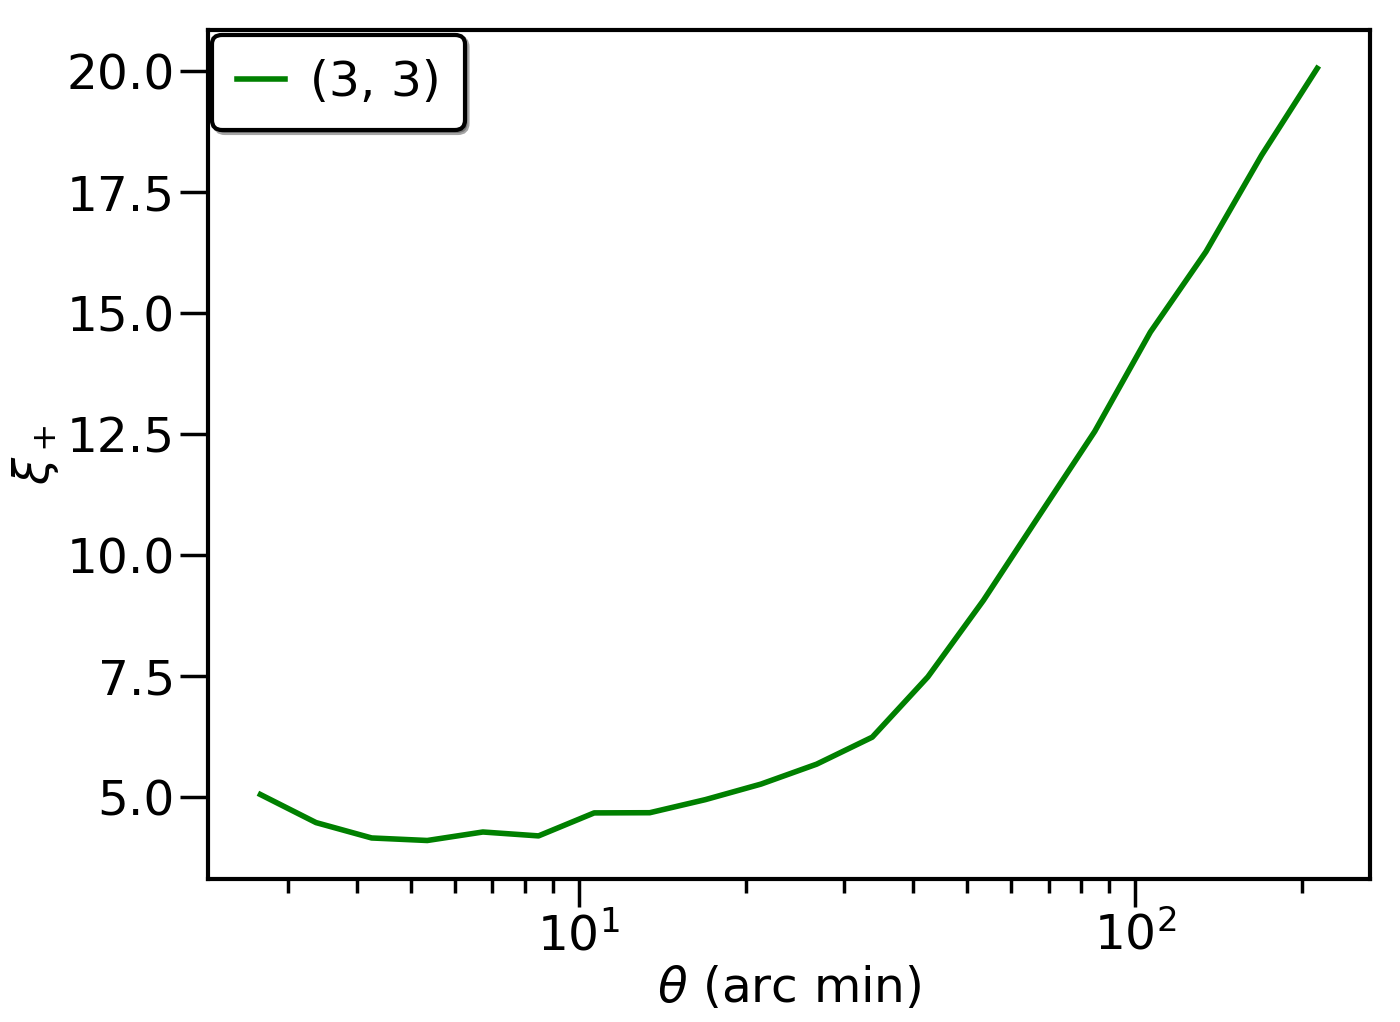

In [37]:
m1m2=(2,2)
nth=20
i2=0
cs=['r','b','c','g','y']
for i in np.arange(nbins):
    j2=0
    for j in np.arange(i,nbins):
        indx0=(i2+j2)*nth
        plot(thb/d2r,np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])/np.diag(cov_des[indx0:indx0+nth,indx0:indx0+nth]),
             label=(i,j),c=cs[(i2+j2)%len(cs)])
        
        j2+=1
    i2+=1
    
    xscale('log')
    # yscale('log')
    xlabel(r'$\theta$ (arc min)')
    ylabel(r'$\xi_+$')
    legend(ncol=3)
    show()

In [38]:
XI_H.cov_utils.Om_W

0.4108824451357524

ValueError: x and y must have same first dimension, but have shapes (20,) and (88999,)

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


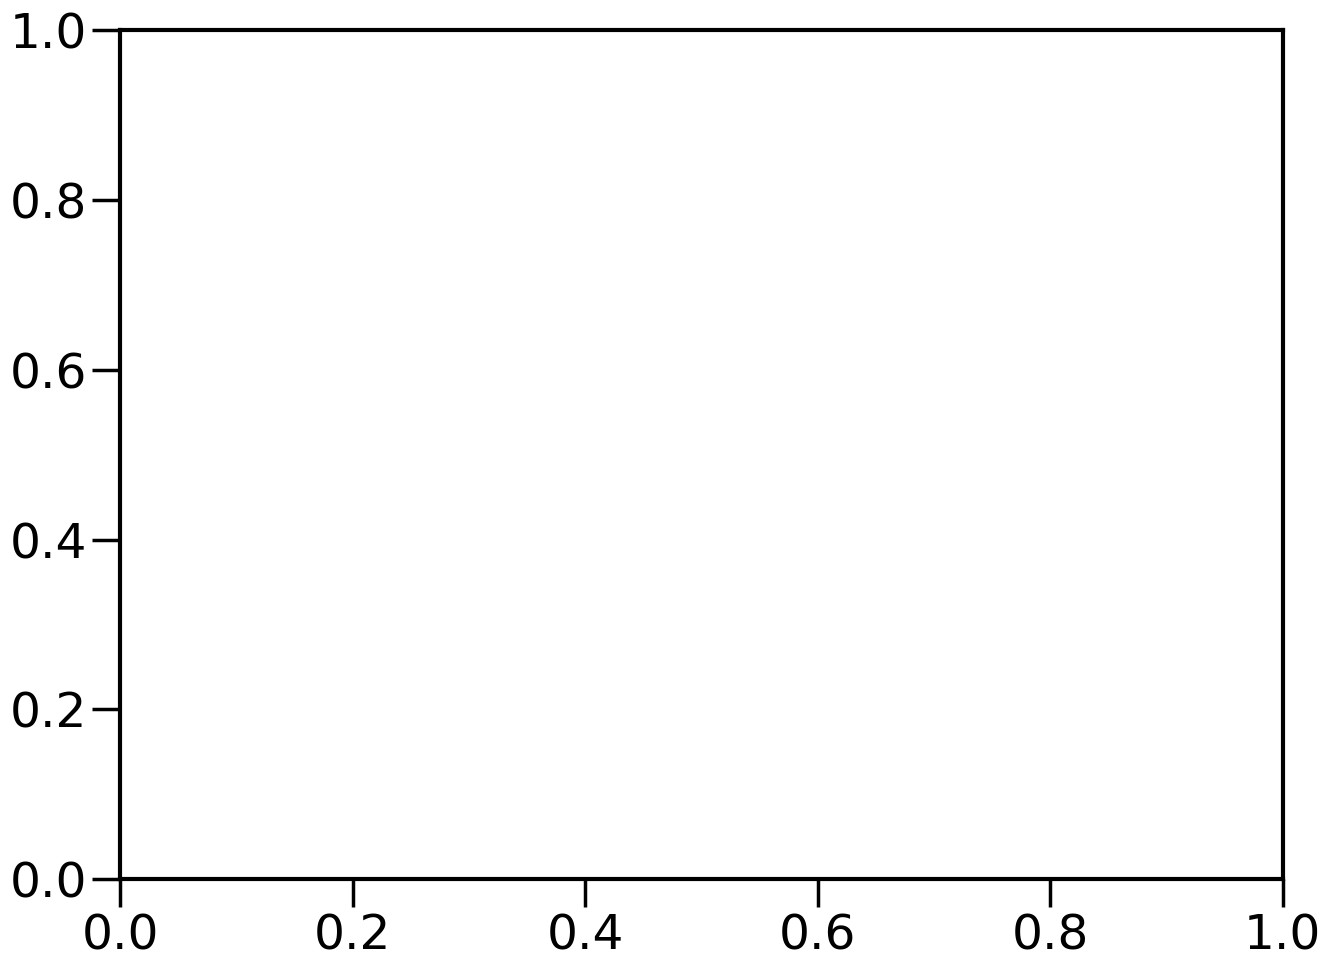

In [40]:
plot(thb/d2r,XI_H.Win)

In [ ]:
win['l']

In [ ]:
plot(win['l'],win['cl'],'bo')
plot(XI_H.cov_utils.window_l,XI_H.cov_utils.Win)
xscale('log')
yscale('log')

In [ ]:
crash

# Galaxy X Lensing Correlation function covariance

In [ ]:
import galaxy_utils
reload(galaxy_utils)
from galaxy_utils import *

In [ ]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [ ]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [ ]:
#Setup redshift bins
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=5  # Number of tomographic bins
z_sigma=0.01
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))

ng0=10 #26+np.inf #ns=inf means shape noise is zero
# nbins=3  # Number of tomographic bins
z_sigma=0.1
zg_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))


# nbins=np.int(nbins*(nbins+1.)/2.)
# zl_bins=lens_wt_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,z_bins=np.linspace(zmin,1.5,nbins),
#                           ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
#                         zp_sigma=z_sigma*np.ones_like(z))

SSV_cov=True
tidal_SSV=False

In [ ]:
do_xi=True
bin_xi=True
bin_cl=True
th_min=1./60
th_max=10
n_th_bins=20
n_th=160
th=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th)
th_bins=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th_bins+1)
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [ ]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
m1m2=(0,2)
m1m2_gg=(0,0)

In [ ]:
# Wigner Transform setup
l_W=np.arange(2,l_max,dtype='int')
WT_kwargs={'l':l_W ,'theta':th*d2r ,'m1_m2':[(0,0),(0,2),(2,2),(2,-2)]}
# %time WTggl=wigner_transform(**WT_kwargs)

XI_W= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zg_bins,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=do_xi,HT=WTggl,
#               HT_kwargs=HT_kwargs,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

In [ ]:
%time cl_Wggl=XI_W.cl_tomo(corrs=[corr_ll,corr_ggl,corr_gg])

In [ ]:
%time xiWggl=XI_W.xi_tomo(corrs=[corr_ll,corr_ggl,corr_gg])
%time xiW_ggl=xiWggl['stack'].compute()

In [ ]:
cl_Wggl['cl'][corr_ggl][(0,0)].compute().min()

In [ ]:
cl_Wggl['cl'].keys()

In [ ]:
cl_Wggl['cov'][corr_ggl+corr_ggl][(0,0,0,1)]['G1423'].compute().min()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,xiWggl['xi'][corr_ggl][m1m2][(i,j)].compute(),label=(i,j))
        plot(thb,xiWggl['xi'][corr_gg][m1m2_gg][(i,j)].compute(),ls='--')
        xscale('log')
        yscale('log')
        xlabel(r'$\theta$ (degrees)')
        ylabel(r'$\xi$')
        legend()
show()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(0,nbins):
        errorbar(thb,xiWggl['xi'][corr_ggl][m1m2][(i,j)].compute(),np.sqrt(np.diag(xiWggl['cov'][corr_ggl+corr_ggl][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        errorbar(thb,xiWggl['xi'][corr_gg][m1m2_gg][(i,j)].compute(),np.sqrt(np.diag(xiWggl['cov'][corr_ggl+corr_ggl][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

In [ ]:
nbins=5

In [ ]:
cc=XI_W.cov_utils
corrW=cc.corr_matrix(xiW_ggl['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
x1=20.*nbins*(nbins+1)/2.
x2=20.*nbins*nbins
hlines(x1,0,len(corrW),lw=2)
vlines(x1,0,len(corrW),lw=2)
hlines(x1*2,0,len(corrW),lw=2)
vlines(x1*2,0,len(corrW),lw=2)
hlines(x1*2+x2,0,len(corrW),lw=2)
vlines(x1*2+x2,0,len(corrW),lw=2)
title('Wigner')
xticks([])
yticks([])
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
import healpy as hp
hp.nside2npix(1024)